In [1]:
import joblib
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

from IPython.display import display

from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, f1_score
from sklearn.model_selection import train_test_split

import seaborn as sns

import sympy as sym
from sympy import Symbol, sympify, lambdify, abc, SympifyError

from sympy import *

import types

import graphviz

from sklearn.preprocessing import MinMaxScaler
from copy import deepcopy

from joblib import Parallel, delayed


sns.set_style("darkgrid")

In [2]:
np.random.seed(42)

## Utility Functions

In [3]:
def calculate_function_values_from_sympy(function, data_points, variable_names=None, n_jobs=-1):
    
    def parallel_evalf(function, function_vars, data_point):
        function_value = function.evalf(subs={var: data_point[index] for index, var in enumerate(list(function_vars))})
        try:
            function_value = float(function_value)
        except TypeError as te:
            #print('te', te)
            #print('function_value', function_value)
            #print('function', function)
            #print('function_vars', function_vars, type(function_vars))
            function_value = np.inf        
            
        return function_value
    
    function_vars = None
    
    if variable_names is None:
        variable_names = ['X' + str(i) for i in range(data_points.shape[1])]
    
    if function is None:
        return np.array([np.nan for i in range(data_points.shape[0])])
    try:
        if variable_names is None:
            function_vars = function.atoms(Symbol)
            print(function_vars)
        else:
            function_vars = [sym.symbols(variable_name, real=True) for variable_name in variable_names]
        #print('function_vars', function_vars)
        lambda_function = lambdify([function_vars], function, modules=["scipy", "numpy"])
        #print('lambda_function', lambda_function)
        #print('data_points[0]', data_points[0])
        if len(function_vars) >= 1:
            function_values = [lambda_function(data_point) for data_point in data_points]
            
        else:
            function_values = [lambda_function() for i in range(data_points.shape[0])]
    except (NameError, KeyError) as e:
        #print(e)
        parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='loky')
        function_values = parallel(delayed(parallel_evalf)(function, function_vars, data_point) for data_point in data_points)  
        function_values = np.array(function_values)

    function_values = np.nan_to_num(function_values).ravel()
                
    return function_values

## Load Histograms and Data Statistics

In [4]:
with open("./data/summarizing_statistics.pkl", 'rb') as f:
    summarizing_statistics = joblib.load(f)

In [5]:
summarizing_statistics

,number_of_datapoints,energy_norm_log_mean,temperature_diff_mean,rms_norm_log_mean,details_ratedhead_mean,energy_norm_log_min,temperature_diff_min,rms_norm_log_min,details_ratedhead_min,energy_norm_log_max,temperature_diff_max,rms_norm_log_max,details_ratedhead_max,Covariance_matrix
on,9680213,1.861944,9.513191,0.730331,105.323685,-5.914482,-24.0,-3.043901,-1.0,9.212087,110.625,6.308744,2403.0,"[[4.054988675775044, 1.6181932043448362, 1.438..."
off,16775063,-3.226129,1.274514,-1.542884,89.319163,-10.605203,-38.875,-4.430309,-1.0,7.588837,109.140903,4.13824,2403.0,"[[1.5394827351582467, 0.21880415026212985, 0.7..."
all,26455276,-1.36436,4.289117,-0.711095,95.175355,-10.605203,-38.875,-4.430309,-1.0,9.212087,110.625,6.308744,2403.0,"[[8.466562429846425, 10.45687699516861, 3.7031..."


In [6]:
with open("./data/hist_on.pkl", 'rb') as f:
    hist_on = joblib.load(f)

In [7]:
with open("./data/hist_off.pkl", 'rb') as f:
    hist_off = joblib.load(f)

In [8]:
print('Total ON:',sum(hist_on.reshape(1,-1)[0]))

Total ON: 9639507


In [9]:
print('Total OFF:',sum(hist_off.reshape(1,-1)[0]))


Total OFF: 16741535


In [10]:
path = "./data/replica_summarizing_statistics.csv"
summarizing_statistics_replica = pd.read_csv(path, index_col=0)

In [11]:
summarizing_statistics_replica

,number_of_datapoints,energy_norm_log_mean,temperature_diff_mean,rms_norm_log_mean,details_ratedhead_mean,energy_norm_log_min,temperature_diff_min,rms_norm_log_min,details_ratedhead_min,energy_norm_log_max,temperature_diff_max,rms_norm_log_max,details_ratedhead_max,Covariance_matrix
on,9680213,1.861944,9.513191,0.730331,105.323685,-5.914482,-24.000000,-3.043901,-1.000000,9.212087,110.625000,6.308744,2403.000000,[[4.05498868e+00 1.61819320e+00 1.43801350e+00...
on_replica,9639507,2.262454,11.145556,0.925975,118.743587,-5.843427,-23.977141,-3.021036,0.000006,10.007755,117.621411,6.767623,2402.992395,[[ 4.60037788e+00 1.66251134e+00 1.59768757e...
off,16775063,-3.226129,1.274514,-1.542884,89.319163,-10.605203,-38.875000,-4.430309,-1.000000,7.588837,109.140903,4.138240,2403.000000,[[ 1.53948274e+00 2.18804150e-01 7.78027734e...
off_replica,16741535,-2.791460,4.517510,-1.396703,107.328826,-10.187956,-38.854668,-4.395695,0.000001,8.527287,108.308373,4.147008,2402.996570,[[ 1.77714623e+00 9.46379299e-02 8.42158723e...
all,26455276,-1.364360,4.289117,-0.711095,95.175355,-10.605203,-38.875000,-4.430309,-1.000000,9.212087,110.625000,6.308744,2403.000000,[[8.46656243e+00 1.04568770e+01 3.70312553e+00...
all_replica,26381042,-0.944784,6.939366,-0.548008,111.499725,-10.187956,-38.854668,-4.395695,0.000001,10.007755,117.621411,6.767623,2402.996570,[[8.73147289e+00 8.43500212e+00 3.84019507e+00...


In [12]:
path = "./data/replica_pump_data.csv"
pump_data_replica = pd.read_csv(path)
print(pump_data_replica.shape)

(26381042, 5)


In [13]:
with open("./data/randForestBest_20201002.pkl", 'rb') as f:
    random_forest_model = joblib.load(f)  

/home/smarton/anaconda3/envs/XAI/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.23.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/home/smarton/anaconda3/envs/XAI/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.23.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


# Insight into Dataframe

In [14]:
pump_data_replica.head()

,energy_norm_log,temperature_diff,rms_norm_log,details_ratedhead,state
0,-4.642337,-0.585072,-2.831278,47.369469,1
1,-4.384410,-2.051363,-2.900545,120.240341,1
2,-5.047895,2.104730,-2.742720,92.577971,1
3,-4.962318,0.375291,-2.975236,75.714544,1
4,-5.082340,-1.878716,-2.900094,19.732252,1


In [15]:
pump_data_replica.describe()

,energy_norm_log,temperature_diff,rms_norm_log,details_ratedhead,state
count,2.638104e+07,2.638104e+07,2.638104e+07,2.638104e+07,2.638104e+07
mean,-9.447840e-01,6.939366e+00,-5.480077e-01,1.114997e+02,3.653952e-01
std,2.954907e+00,9.601409e+00,1.405737e+00,1.955414e+02,4.815408e-01
min,-1.018796e+01,-3.885467e+01,-4.395695e+00,1.166256e-06,0.000000e+00
25%,-3.370447e+00,1.604493e+00,-1.821002e+00,3.801559e+01,0.000000e+00
50%,-2.187638e+00,4.925288e+00,-9.366825e-01,7.603490e+01,0.000000e+00
75%,1.350225e+00,8.834380e+00,5.890607e-01,1.140766e+02,1.000000e+00
max,1.000776e+01,1.176214e+02,6.767623e+00,2.402997e+03,1.000000e+00


In [16]:
pump_data_replica.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26381042 entries, 0 to 26381041
Data columns (total 5 columns):
 #   Column             Dtype  
---  ------             -----  
 0   energy_norm_log    float64
 1   temperature_diff   float64
 2   rms_norm_log       float64
 3   details_ratedhead  float64
 4   state              int64  
dtypes: float64(4), int64(1)
memory usage: 1006.4 MB


In [17]:
legend_fontsize = 25
label_fontsize = 35
plot_fontsize = 30

figsize = (15, 9)
legend_loc = 2

color_1 = '#84b7e9'#'#c0d6ff'
color_2 = '#0a6fd3'#'#96bcff'
color_3 = '#06427e'#'#6ca1ff'


Text(0, 0.5, 'Frequency')

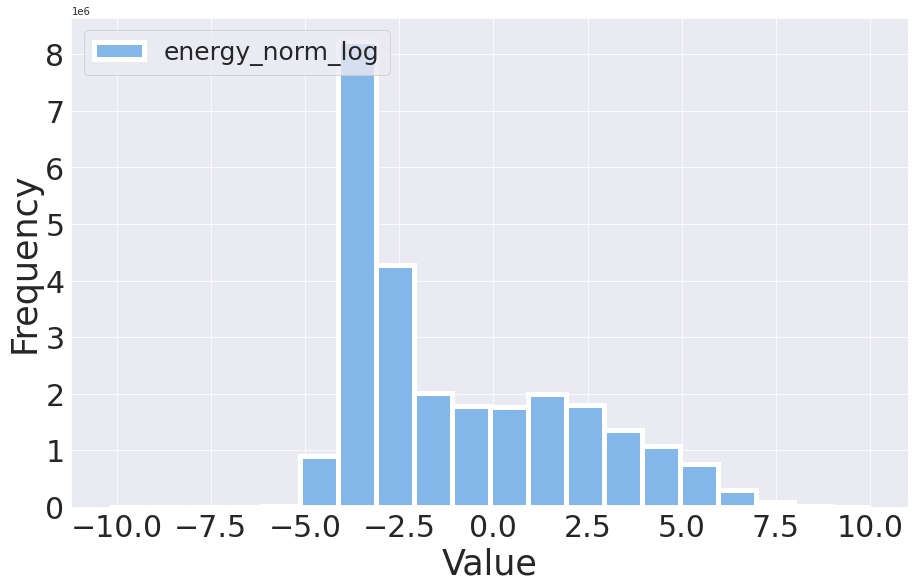

In [18]:
axes = pump_data_replica['energy_norm_log'].plot.hist(bins=20, 
                                               color=[color_1, color_2, color_3],
                                               #alpha=0.5,
                                               rot=0, 
                                               stacked=True,
                                               figsize=figsize, 
                                               fontsize=plot_fontsize, 
                                               linewidth=5)
#axes.ticklabel_format(useOffset=False, style='plain')
axes.legend(fontsize=legend_fontsize, loc = legend_loc) # loc=2
axes.set_xlabel('Value', fontsize=label_fontsize)
axes.set_ylabel('Frequency', fontsize=label_fontsize)

Text(0, 0.5, 'Frequency')

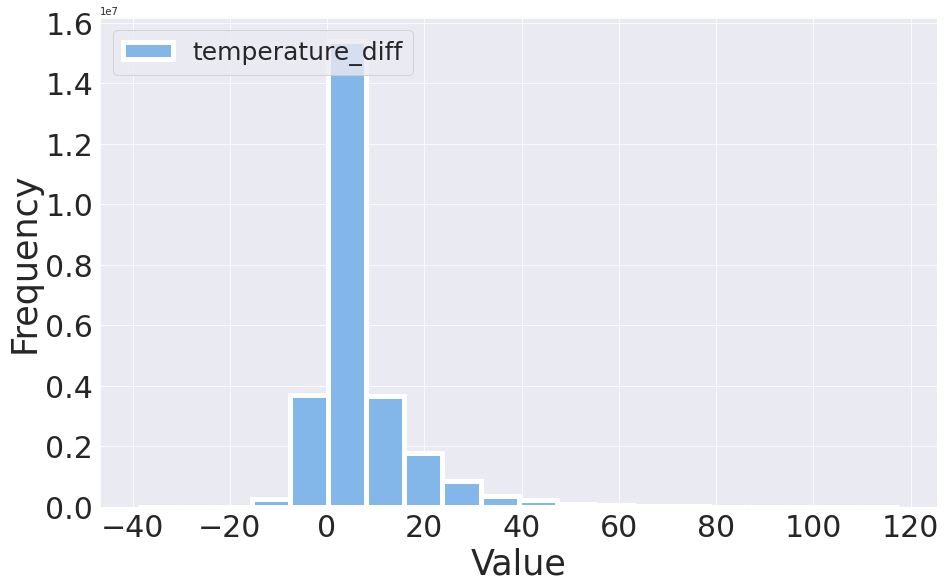

In [19]:
axes = pump_data_replica['temperature_diff'].plot.hist(bins=20, 
                                               color=[color_1, color_2, color_3],
                                               #alpha=0.5,
                                               rot=0, 
                                               stacked=True,
                                               figsize=figsize, 
                                               fontsize=plot_fontsize, 
                                               linewidth=5)
#axes.ticklabel_format(useOffset=False, style='plain')
axes.legend(fontsize=legend_fontsize, loc = legend_loc) # loc=2
axes.set_xlabel('Value', fontsize=label_fontsize)
axes.set_ylabel('Frequency', fontsize=label_fontsize)

Text(0, 0.5, 'Frequency')

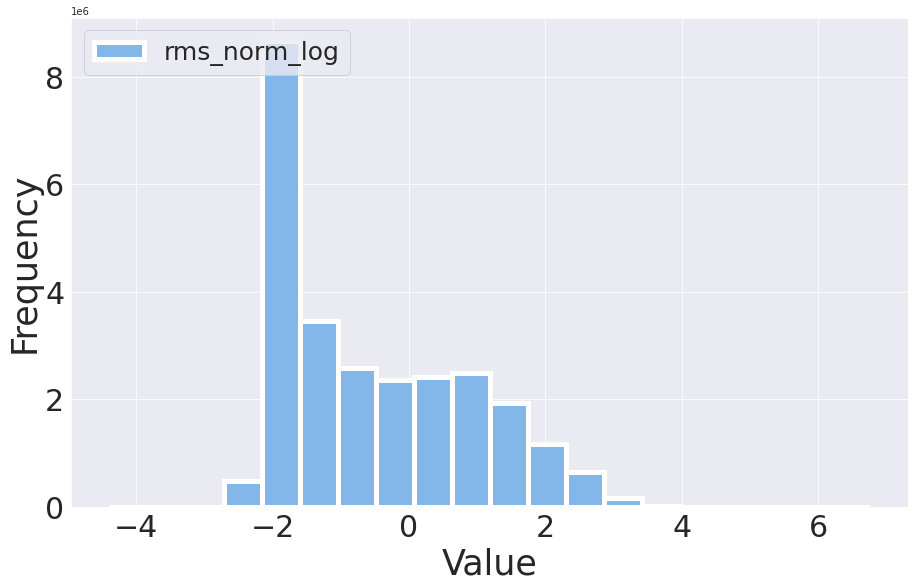

In [20]:
axes = pump_data_replica['rms_norm_log'].plot.hist(bins=20, 
                                               color=[color_1, color_2, color_3],
                                               #alpha=0.5,
                                               rot=0, 
                                               stacked=True,
                                               figsize=figsize, 
                                               fontsize=plot_fontsize, 
                                               linewidth=5)
#axes.ticklabel_format(useOffset=False, style='plain')
axes.legend(fontsize=legend_fontsize, loc = legend_loc) # loc=2
axes.set_xlabel('Value', fontsize=label_fontsize)
axes.set_ylabel('Frequency', fontsize=label_fontsize)

Text(0, 0.5, 'Frequency')

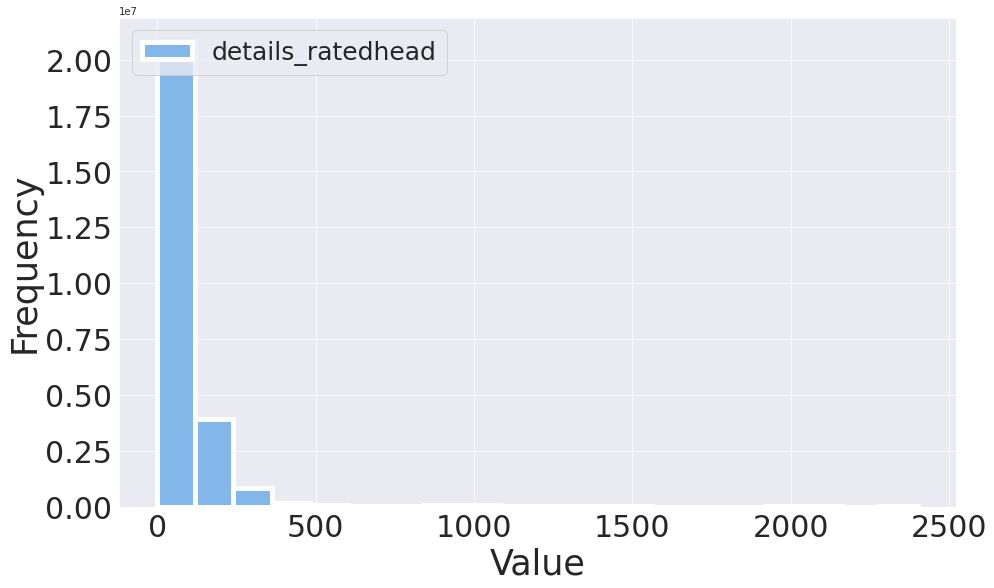

In [21]:
axes = pump_data_replica['details_ratedhead'].plot.hist(bins=20, 
                                               color=[color_1, color_2, color_3],
                                               #alpha=0.5,
                                               rot=0, 
                                               stacked=True,
                                               figsize=figsize, 
                                               fontsize=plot_fontsize, 
                                               linewidth=5)
#axes.ticklabel_format(useOffset=False, style='plain')
axes.legend(fontsize=legend_fontsize, loc = legend_loc) # loc=2
axes.set_xlabel('Value', fontsize=label_fontsize)
axes.set_ylabel('Frequency', fontsize=label_fontsize)

## Generate Data For Symbolic Metamodeling

In [22]:
pump_data_replica.head()

,energy_norm_log,temperature_diff,rms_norm_log,details_ratedhead,state
0,-4.642337,-0.585072,-2.831278,47.369469,1
1,-4.384410,-2.051363,-2.900545,120.240341,1
2,-5.047895,2.104730,-2.742720,92.577971,1
3,-4.962318,0.375291,-2.975236,75.714544,1
4,-5.082340,-1.878716,-2.900094,19.732252,1


In [23]:
data= pump_data_replica.sample(n=100_000)

X_data = data.drop(['state'], axis=1) #frac=0.1
y_data = data[['state']] #frac=0.1

In [24]:
X_data_scaled = np.empty_like(X_data.values.T)
scaler_list = []

for index, feature in enumerate(X_data.values.T):
    
    scaler = MinMaxScaler(feature_range=(1e-4, 1))
    scaler.fit(feature.reshape(-1, 1))
    scaler_list.append(scaler)
    
    feature_scaled = scaler.transform(feature.reshape(-1, 1)).ravel()
    
    X_data_scaled[index] = feature_scaled
    
X_data_scaled = pd.DataFrame(data= X_data_scaled.T, index=X_data.index, columns=list(X_data.columns))

In [25]:
#X_train_with_valid, X_test, y_train_with_valid, y_test = train_test_split(X_data, y_data, test_size=0.25, random_state=42)           
#X_train, X_valid, y_train, y_valid= train_test_split(X_train_with_valid, y_train_with_valid, test_size=0.25, random_state=42)   

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.25, random_state=42)  


#X_data_scaled = data_scaled.values 
#X_train_with_valid_scaled, X_test_scaled = train_test_split(X_data_scaled, test_size=0.25, random_state=42)           
#X_train_scaled, X_valid_scaled = train_test_split(X_train_with_valid_scaled, test_size=0.25, random_state=42)   

X_train_scaled, X_test_scaled = train_test_split(X_data_scaled, test_size=0.25, random_state=42)  


In [26]:
print(X_data.shape)
print(X_train.shape)
#print(X_valid.shape)
print(X_test.shape)
print()

print(X_data_scaled.shape)
print(X_train_scaled.shape)
#print(X_valid_scaled.shape)
print(X_test_scaled.shape)
print()

print(y_data.shape)
print(y_train.shape)
#print(y_valid.shape)
print(y_test.shape)

(100000, 4)
(75000, 4)
(25000, 4)

(100000, 4)
(75000, 4)
(25000, 4)

(100000, 1)
(75000, 1)
(25000, 1)


In [27]:
X_data.head()

,energy_norm_log,temperature_diff,rms_norm_log,details_ratedhead
13880350,-3.046441,3.142118,-2.153672,2.049436
13018525,-3.253409,1.100728,-1.834407,74.941685
22758968,0.151482,6.601620,0.143500,45.284839
26049008,-3.156811,7.770997,-1.850652,472.412949
4688620,0.485113,9.553305,1.172251,54.346425


In [28]:
X_data_scaled.head()

,energy_norm_log,temperature_diff,rms_norm_log,details_ratedhead
13880350,0.187314,0.199147,0.129700,0.000953
13018525,0.174365,0.183699,0.169780,0.031301
22758968,0.387395,0.225329,0.418088,0.018954
26049008,0.180409,0.234178,0.167741,0.196789
4688620,0.408269,0.247666,0.547238,0.022727


In [29]:
y_data.head()

,state
13880350,0
13018525,0
22758968,0
26049008,0
4688620,1


In [30]:
X_data.describe()

,energy_norm_log,temperature_diff,rms_norm_log,details_ratedhead
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,-0.926132,6.883145,-0.541237,110.873149
std,2.960861,9.571795,1.407717,191.522362
min,-6.038717,-23.159554,-3.186004,0.001450
25%,-3.366720,1.573012,-1.820031,38.097587
50%,-2.158722,4.893059,-0.923792,75.893879
75%,1.372991,8.750042,0.597593,114.209613
max,9.942830,108.964905,4.778744,2401.582094


In [31]:
X_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 13880350 to 8425222
Data columns (total 4 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   energy_norm_log    100000 non-null  float64
 1   temperature_diff   100000 non-null  float64
 2   rms_norm_log       100000 non-null  float64
 3   details_ratedhead  100000 non-null  float64
dtypes: float64(4)
memory usage: 3.8 MB


In [32]:
accuracy_score(np.round(np.clip(data['energy_norm_log'].values * 1.631, 0, 1)).astype(int), data['state'].values)

0.90677

# Symbolic Metamodeling

In [33]:
metamodeling_hyperparams = {
    'num_iter': 100,#500,
    'batch_size': 128,
    'learning_rate': 0.001,        
    'dataset_size': 5000,
    'exact_expression': True,
    'flat_function': False,
    'polynomial_degree': 3,
    'early_stopping': 50,
    'restarts': 10,
}

return_error = True

symbolic_metamodeling = False
symbolic_metamodeling_adjusted = True

## Evaluate Model

In [34]:
y_test_random_forest = random_forest_model.predict(X_test)

accuracy_random_forest = accuracy_score(y_test, y_test_random_forest)
f1_random_forest = f1_score(y_test, y_test_random_forest)

print('Accuracy: '+ str(accuracy_random_forest))
print('F1 Score: '+ str(f1_random_forest))


Accuracy: 0.90676
F1 Score: 0.8706221901537438


In [35]:
if symbolic_metamodeling:
    from pysymbolic_original.algorithms.symbolic_metamodeling import symbolic_metamodel
    from pysymbolic_original.algorithms.symbolic_expressions import get_symbolic_model
    
    
    ## Symbolic Metamodeling
    if metamodeling_hyperparams['batch_size'] == None:
        metamodeling_hyperparams['batch_size'] = X_data.shape[0]

    metamodel = symbolic_metamodel(random_forest_model, 
                                   X_train[:metamodeling_hyperparams['dataset_size']], 
                                   mode="classification")

    metamodel.fit(num_iter=metamodeling_hyperparams['num_iter'], 
                  batch_size=metamodeling_hyperparams['batch_size'], 
                  learning_rate=metamodeling_hyperparams['learning_rate'])   


    if metamodeling_hyperparams['exact_expression']:
        metamodel_function = metamodel.exact_expression
        #print(metamodel_function)
    else:
        metamodel_function = metamodel.approx_expression
        #print(metamodel_function)


    y_test_metamodel = np.round(metamodel.evaluate(X_test)).astype(np.int64)
    y_test_model = random_forest_model.predict(X_test)

    accuracy_model_performance = accuracy_score(y_test, y_test_model)    
    accuracy_metamodel_performance = accuracy_score(y_test, y_test_metamodel) 

    accuracy_fidelity = accuracy_score(y_test_model, y_test_metamodel)     
    
    display(metamodel_function)
    
    print('Accuracy Random Forest Model:', accuracy_model_performance)
    print('Accuracy Symbolic Metaodel:', accuracy_metamodel_performance)
    
    print('Fidelity (Accuracy) Symbolic Metaodel - Random Forest Model:', accuracy_model_performance)

        


In [36]:
random_forest_model_scaled = deepcopy(random_forest_model)

for dt in random_forest_model_scaled.estimators_:

    n_nodes = dt.tree_.node_count
    children_left = dt.tree_.children_left
    children_right = dt.tree_.children_right
    feature = dt.tree_.feature
    threshold = dt.tree_.threshold

    node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
    is_leaves = np.zeros(shape=n_nodes, dtype=bool)
    stack = [(0, 0)]  # start with the root node id (0) and its depth (0)
    while len(stack) > 0:
        # `pop` ensures each node is only visited once
        node_id, depth = stack.pop()
        node_depth[node_id] = depth

        # If the left and right child of a node is not the same we have a split
        # node
        is_split_node = children_left[node_id] != children_right[node_id]
        # If a split node, append left and right children and depth to `stack`
        # so we can loop through them
        if is_split_node:
            stack.append((children_left[node_id], depth + 1))
            stack.append((children_right[node_id], depth + 1))
        else:
            is_leaves[node_id] = True

    for i in range(n_nodes):
        if not is_leaves[i]: 
            threshold[i] = scaler_list[int(feature[i])].transform(np.array([threshold[i]]).reshape(1, -1)).ravel()[0]

In [ ]:
if symbolic_metamodeling_adjusted:
    from pysymbolic_adjusted.algorithms.symbolic_metamodeling import symbolic_metamodel
    from pysymbolic_adjusted.algorithms.symbolic_expressions import get_symbolic_model    
    
    ## Symbolic Metamodeling
    if metamodeling_hyperparams['batch_size'] == None:
        metamodeling_hyperparams['batch_size'] = X_train_scaled.shape[0]

    metamodel = symbolic_metamodel(random_forest_model_scaled, #random_forest_model, #model,#
                                   X_train_scaled[:metamodeling_hyperparams['dataset_size']], #X_train, #X_train_abse,#
                                   mode="classification", 
                                   approximation_order = metamodeling_hyperparams['polynomial_degree'], 
                                   force_polynomial=metamodeling_hyperparams['flat_function'],
                                   verbosity=True,
                                   early_stopping=metamodeling_hyperparams['early_stopping'],
                                   restarts=metamodeling_hyperparams['restarts'])

    metamodel.fit(num_iter=metamodeling_hyperparams['num_iter'], 
                  batch_size=metamodeling_hyperparams['batch_size'], 
                  learning_rate=metamodeling_hyperparams['learning_rate'])    

    if metamodeling_hyperparams['exact_expression']:
        metamodel_function = metamodel.exact_expression
        #print(metamodel_function)
    else:
        metamodel_function = metamodel.approx_expression
        #print(metamodel_function)

    y_test_metamodel_eval = np.round(metamodel.evaluate(X_test_scaled)).astype(np.int64)
    
    y_test_metamodel = np.round(np.clip(calculate_function_values_from_sympy(metamodel_function, X_test_scaled), 0, 1)).astype(np.int64).reshape(-1,1)#np.round(calculate_function_values_from_sympy(metamodel_function, X_test)).astype(np.int64)

    
    y_test_model = random_forest_model_scaled.predict(X_test_scaled)

    accuracy_model_performance = accuracy_score(y_test, y_test_model)    
    accuracy_metamodel_performance = accuracy_score(y_test, y_test_metamodel) 
    accuracy_metamodel_performance_eval = accuracy_score(y_test, y_test_metamodel_eval) 
    
    accuracy_fidelity = accuracy_score(y_test_model, y_test_metamodel)     
    accuracy_fidelity_eval = accuracy_score(y_test_model, y_test_metamodel_eval)   
    
    f1_model_performance = f1_score(y_test, y_test_model)    
    f1_metamodel_performance = f1_score(y_test, y_test_metamodel) 
    f1_metamodel_performance_eval = f1_score(y_test, y_test_metamodel_eval) 
    
    f1_fidelity = f1_score(y_test_model, y_test_metamodel)     
    f1_fidelity_eval = f1_score(y_test_model, y_test_metamodel_eval)      
    
    display(metamodel_function)
    
    print('Accuracy Random Forest Model:', accuracy_model_performance)
    print('Accuracy Symbolic Metaodel:', accuracy_metamodel_performance)
    print('Accuracy Symbolic Metaodel Eval:', accuracy_metamodel_performance_eval)
    
    print('Fidelity (Accuracy) Symbolic Metaodel - Random Forest Model:', accuracy_fidelity)
    print('Fidelity (Accuracy) Symbolic Metaodel Eval - Random Forest Model:', accuracy_fidelity_eval)
    
    print('F1 Score Random Forest Model:', f1_model_performance)
    print('F1 Score Symbolic Metaodel:', f1_metamodel_performance)
    print('F1 Score Symbolic Metaodel Eval:', f1_metamodel_performance_eval)
    
    print('Fidelity (F1 Score) Symbolic Metaodel - Random Forest Model:', f1_fidelity)
    print('Fidelity (F1 Score) Symbolic Metaodel Eval - Random Forest Model:', f1_fidelity_eval)

2021-09-14 21:22:11.116097: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


---- Tuning the basis functions ----


basis function loop:   0%|          | 0/4 [00:00<?, ?it/s]

2021-09-14 21:22:13.492420: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set

restart loop:   0%|          | 0/11 [00:00<?, ?it/s]2021-09-14 21:22:13.493325: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-10.1/lib64:
2021-09-14 21:22:13.493346: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2021-09-14 21:22:13.493372: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (dws-11): /proc/driver/nvidia/version does not exist
2021-09-14 21:22:13.496089: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set


iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 35.826
Iteration: 1 	--- Loss: 37.474
Iteration: 2 	--- Loss: 36.713
Iteration: 3 	--- Loss: 36.662
Iteration: 4 	--- Loss: 36.968
Iteration: 5 	--- Loss: 38.327
Iteration: 6 	--- Loss: 35.130
Iteration: 7 	--- Loss: 38.107
Iteration: 8 	--- Loss: 34.494
Iteration: 9 	--- Loss: 35.849
Iteration: 10 	--- Loss: 37.367
Iteration: 11 	--- Loss: 35.059
Iteration: 12 	--- Loss: 36.307
Iteration: 13 	--- Loss: 34.412
Iteration: 14 	--- Loss: 36.002
Iteration: 15 	--- Loss: 32.886
Iteration: 16 	--- Loss: 33.176
Iteration: 17 	--- Loss: 35.439
Iteration: 18 	--- Loss: 33.418
Iteration: 19 	--- Loss: 33.460
Iteration: 20 	--- Loss: 34.150
Iteration: 21 	--- Loss: 34.056
Iteration: 22 	--- Loss: 33.450
Iteration: 23 	--- Loss: 33.721
Iteration: 24 	--- Loss: 35.871
Iteration: 25 	--- Loss: 34.437
Iteration: 26 	--- Loss: 39.773
Iteration: 27 	--- Loss: 39.333
Iteration: 28 	--- Loss: 40.141
Iteration: 29 	--- Loss: 41.467
Iteration: 30 	--- Loss: 38.409
Iteration: 31 	---


restart loop:   9%|▉         | 1/11 [11:59<1:59:57, 719.75s/it]

Iteration: 127 	--- Loss: 31.297
Early Stopping requirement reached after 127 Iterations
New Global Minimum: 27.91507268855627


iter loop:   0%|          | 0/500 [00:00<?, ?it/s]

Iteration: 0 	--- Loss: 35.879
Iteration: 1 	--- Loss: 35.857
Iteration: 2 	--- Loss: 36.037
Iteration: 3 	--- Loss: 35.994
Iteration: 4 	--- Loss: 36.239
Iteration: 5 	--- Loss: 37.199
Iteration: 6 	--- Loss: 36.873
Iteration: 7 	--- Loss: 38.292
Iteration: 8 	--- Loss: 39.770
Iteration: 9 	--- Loss: 37.484
Iteration: 10 	--- Loss: 36.395
Iteration: 11 	--- Loss: 36.824
Iteration: 12 	--- Loss: 36.731
Iteration: 13 	--- Loss: 38.283
Iteration: 14 	--- Loss: 36.194
Iteration: 15 	--- Loss: 36.227
Iteration: 16 	--- Loss: 36.188
Iteration: 17 	--- Loss: 34.557
Iteration: 18 	--- Loss: 36.889
Iteration: 19 	--- Loss: 35.892
Iteration: 20 	--- Loss: 36.214
Iteration: 21 	--- Loss: 36.749
Iteration: 22 	--- Loss: 34.620
Iteration: 23 	--- Loss: 36.050
Iteration: 24 	--- Loss: 35.610
Iteration: 25 	--- Loss: 33.672
Iteration: 26 	--- Loss: 35.077
Iteration: 27 	--- Loss: 35.093
Iteration: 28 	--- Loss: 35.079
Iteration: 29 	--- Loss: 36.541
Iteration: 30 	--- Loss: 36.188
Iteration: 31 	---

In [ ]:
y_test_metamodel_eval = np.round(metamodel.evaluate(X_test_scaled.values)).astype(np.int64)

accuracy_metamodel_performance_eval = accuracy_score(y_test, y_test_metamodel_eval) 
accuracy_fidelity_eval = accuracy_score(y_test_model, y_test_metamodel_eval)   
f1_metamodel_performance_eval = f1_score(y_test, y_test_metamodel_eval) 
f1_fidelity_eval = f1_score(y_test_model, y_test_metamodel_eval)      

print('Accuracy Symbolic Metaodel Eval:', accuracy_metamodel_performance_eval)
print('Fidelity (Accuracy) Symbolic Metaodel Eval - Random Forest Model:', accuracy_fidelity_eval)
print('F1 Score Symbolic Metaodel Eval:', f1_metamodel_performance_eval)
print('Fidelity (F1 Score) Symbolic Metaodel Eval - Random Forest Model:', f1_fidelity_eval)

In [ ]:
    
y_test_metamodel = np.round(np.clip(calculate_function_values_from_sympy(metamodel_function, X_test_scaled.values), 0, 1)).astype(np.int64).reshape(-1,1)#np.round(calculate_function_values_from_sympy(metamodel_function, X_test)).astype(np.int64)


y_test_model = random_forest_model_scaled.predict(X_test_scaled.values)

accuracy_model_performance = accuracy_score(y_test, y_test_model)    
accuracy_metamodel_performance = accuracy_score(y_test, y_test_metamodel) 

accuracy_fidelity = accuracy_score(y_test_model, y_test_metamodel)     

f1_model_performance = f1_score(y_test, y_test_model)    
f1_metamodel_performance = f1_score(y_test, y_test_metamodel) 

f1_fidelity = f1_score(y_test_model, y_test_metamodel)     

display(metamodel_function)

print('Accuracy Random Forest Model:', accuracy_model_performance)
print('Accuracy Symbolic Metaodel:', accuracy_metamodel_performance)

print('Fidelity (Accuracy) Symbolic Metaodel - Random Forest Model:', accuracy_fidelity)

print('F1 Score Random Forest Model:', f1_model_performance)
print('F1 Score Symbolic Metaodel:', f1_metamodel_performance)

print('Fidelity (F1 Score) Symbolic Metaodel - Random Forest Model:', f1_fidelity)


In [ ]:
metamodel.exact_expression

In [ ]:
metamodel.approx_expression

In [ ]:
approx_fv = np.round(np.clip(calculate_function_values_from_sympy(metamodel.approx_expression, X_test_scaled.values), 0, 1)).astype(np.int64).reshape(-1,1)

In [ ]:
exact_fv = np.round(np.clip(calculate_function_values_from_sympy(metamodel.exact_expression, X_test_scaled.values), 0, 1)).astype(np.int64).reshape(-1,1)

In [ ]:
f1_score(y_test_model, approx_fv)    

In [ ]:
f1_score(y_test, approx_fv)  

In [ ]:
f1_score(y_test_model, exact_fv)  

In [ ]:
f1_score(y_test, exact_fv)  

In [ ]:
accuracy_score(y_test_model, approx_fv)   

In [ ]:
accuracy_score(y_test, approx_fv)  

In [ ]:
accuracy_score(y_test_model, exact_fv)  

In [ ]:
accuracy_score(y_test, exact_fv)  

In [ ]:
print('Accuracy Random Forest Model:', accuracy_model_performance)
print('Accuracy Symbolic Metaodel:', accuracy_metamodel_performance)
print('Accuracy Symbolic Metaodel Eval:', accuracy_metamodel_performance_eval)

print('Fidelity (Accuracy) Symbolic Metaodel - Random Forest Model:', accuracy_fidelity)
print('Fidelity (Accuracy) Symbolic Metaodel Eval - Random Forest Model:', accuracy_fidelity_eval)

print('F1 Score Random Forest Model:', f1_model_performance)
print('F1 Score Symbolic Metaodel:', f1_metamodel_performance)
print('F1 Score Symbolic Metaodel Eval:', f1_metamodel_performance_eval)

print('Fidelity (F1 Score) Symbolic Metaodel - Random Forest Model:', f1_fidelity)
print('Fidelity (F1 Score) Symbolic Metaodel Eval - Random Forest Model:', f1_fidelity_eval)